#### 6

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(1,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)

var_countries  <-  dim(read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
this_file_models_list  <-  list()
this_model_list  <-  list()

    


In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    


    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }
this_file_models_list[[1]]  <-  this_model_list



[1]   1  84  85 108


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”

          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”

[1]  25 108 109 132
|[1]  37 120 121 144
|[1]  49 132 133 156


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12164.551 -16635.044 -14786.720 -10117.149  -3311.032  11477.168
 [7]  16114.694   3405.818   2499.181  -3603.733 -12847.751 -34380.551
[13] -15402.820 -16873.872 -13835.436 -14739.710  -4128.032  10901.836
[19]  11308.139   3839.539   2644.410  -5052.194 -11349.669 -34492.999

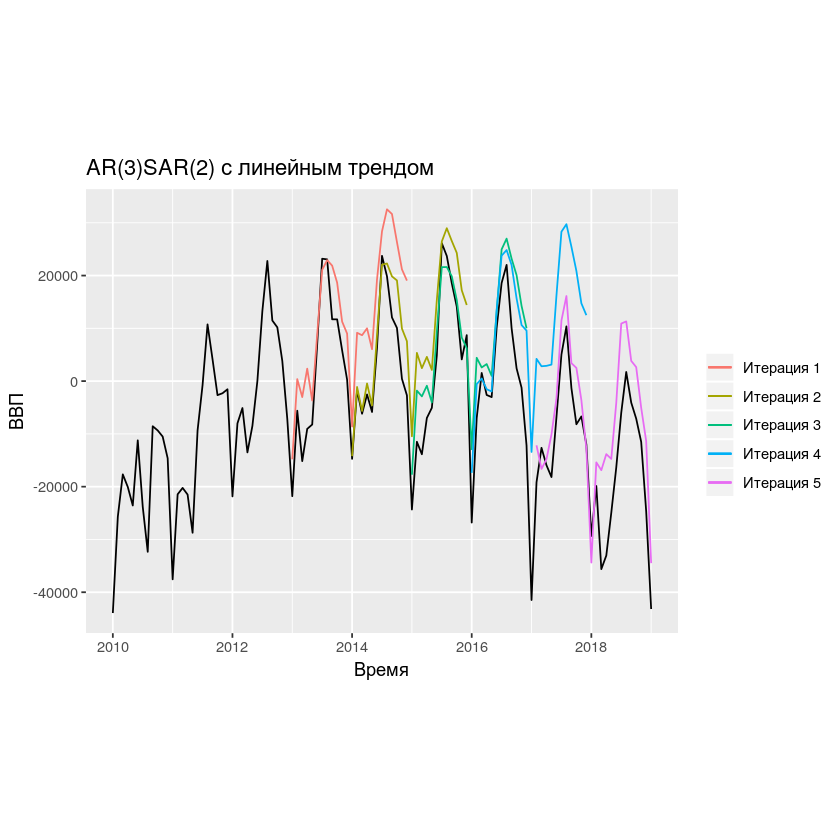

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-9869.563,11592.416,490.5014,1
-6814.885,8652.214,178.3644,13
-6484.673,9211.468,148.4627,25
-15069.090,17751.237,274.0267,37
-7417.688,9604.094,102.4801,50


In [15]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
-9131.180 11362.286   238.767    25.200

In [16]:
df_mean_acc <- readRDS("df_mean_acc_noweights.rds")

df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,12126.13
2 level (state),85.22300,305.4990,12131.18
2 level (type),75.78587,352.6453,11896.23
2 level (clusetered),77.77636,271.5424,12057.29


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12131.18
2 level (type),75.78587,352.6453,11896.23
2 level (clusetered),77.77636,271.5424,12057.29


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-9869.563,11592.416,490.5014,1
-6814.885,8652.214,178.3644,13
-6484.673,9211.468,148.4627,25
-15069.090,17751.237,274.0267,37
-7417.688,9604.094,102.4801,50


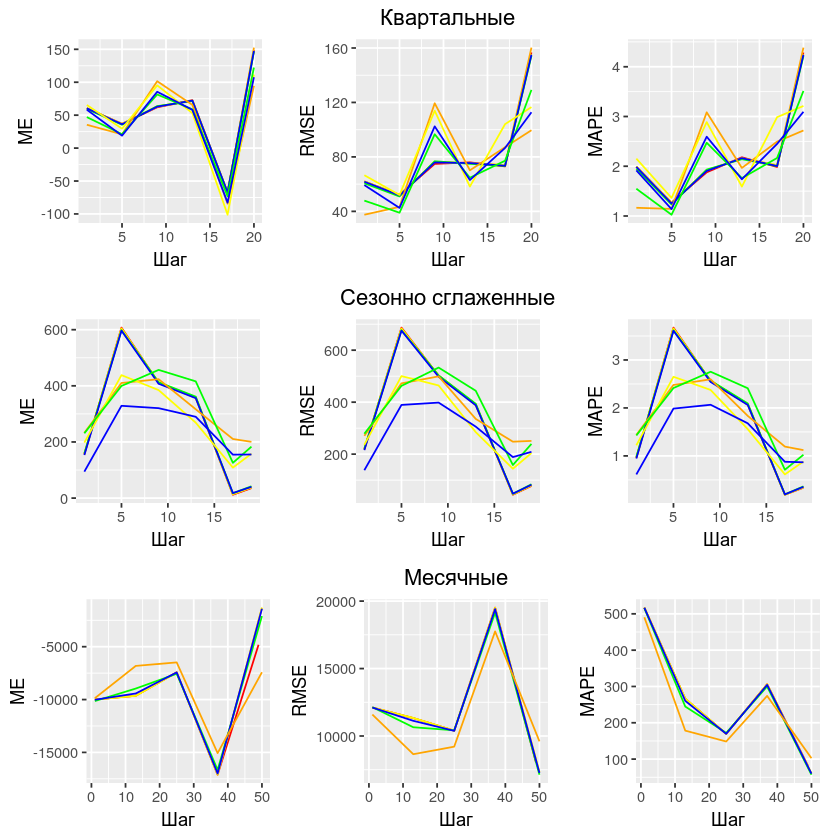

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all_noweights.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[2]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-9935.161,11929.67,523.5212,1
-10258.052,11832.07,276.6753,13
-8551.295,11090.51,187.0958,25
-15618.322,18280.90,290.9257,37
-9094.783,11232.13,130.8335,50


In [27]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13559.4593 -11103.3657 -10215.5992  -9459.0942   1003.3806  13922.6729
 [7]  16004.0610   7041.8833   2132.1032  -3525.6031  -8527.2409 -36043.9556
[13] -14246.6722 -11230.3253 -11158.8256 -11076.0276    165.7420  12350.4250
[19]  14138.5660   5434.7472    793.9816  -5101.8675 -10928.8464 -38090.8879

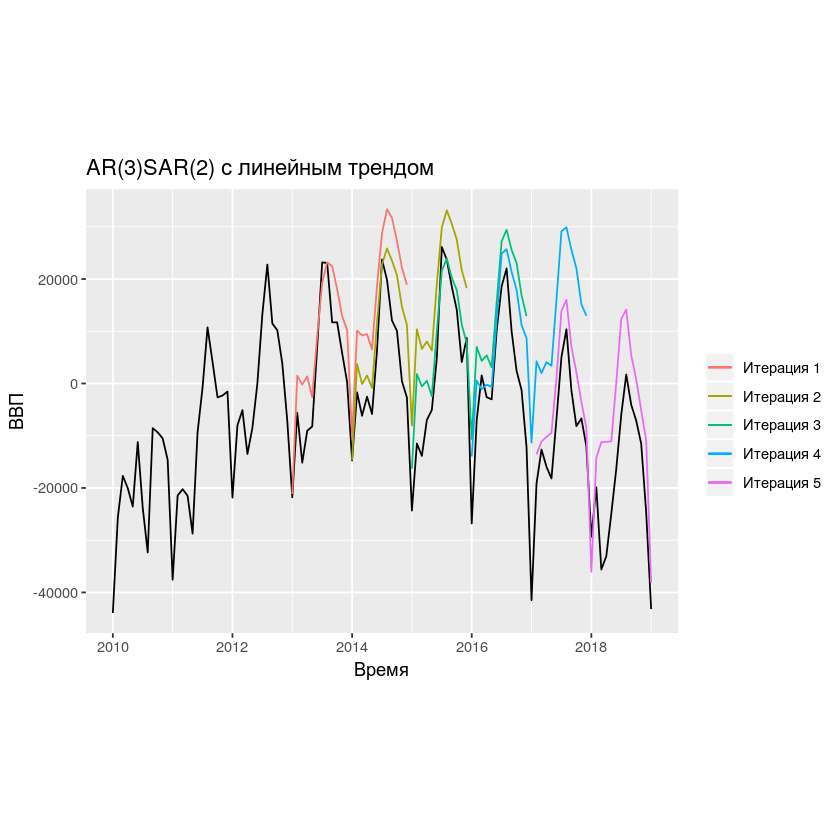

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10691.5225  12873.0550    281.8103     25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12873.06
2 level (type),75.78587,352.6453,11896.23
2 level (clusetered),77.77636,271.5424,12057.29


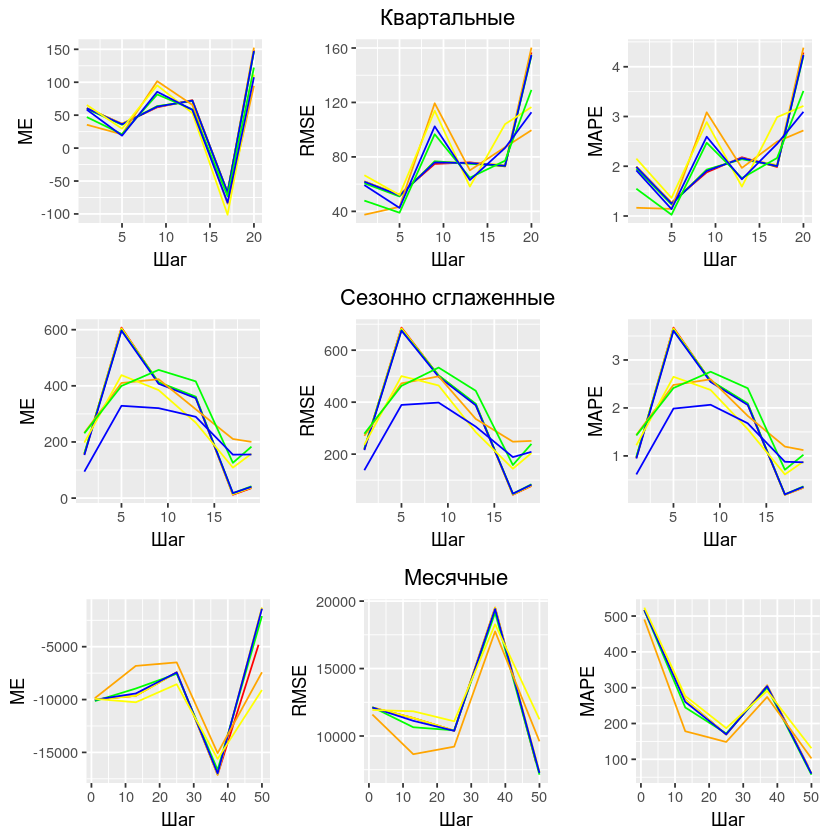

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[3]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-10729.382,12491.977,511.34966,1
-6246.052,8115.158,160.94854,13
-8105.763,10662.252,182.89752,25
-14832.079,17768.230,275.44122,37
-5695.221,8705.609,63.10856,50


In [40]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12551.2305 -16784.8900 -10556.1723  -7934.8379  -4533.6963  13318.9228
 [7]  12452.1125   -487.7654   3152.8859  -6823.5898 -16214.1680 -35808.7463
[13] -18735.6295 -19594.8120 -11698.4704 -16319.5271  -6405.1922   9369.8686
[19]   4260.2038   -446.2929    653.9886 -10435.4796 -14272.0580 -36475.1140

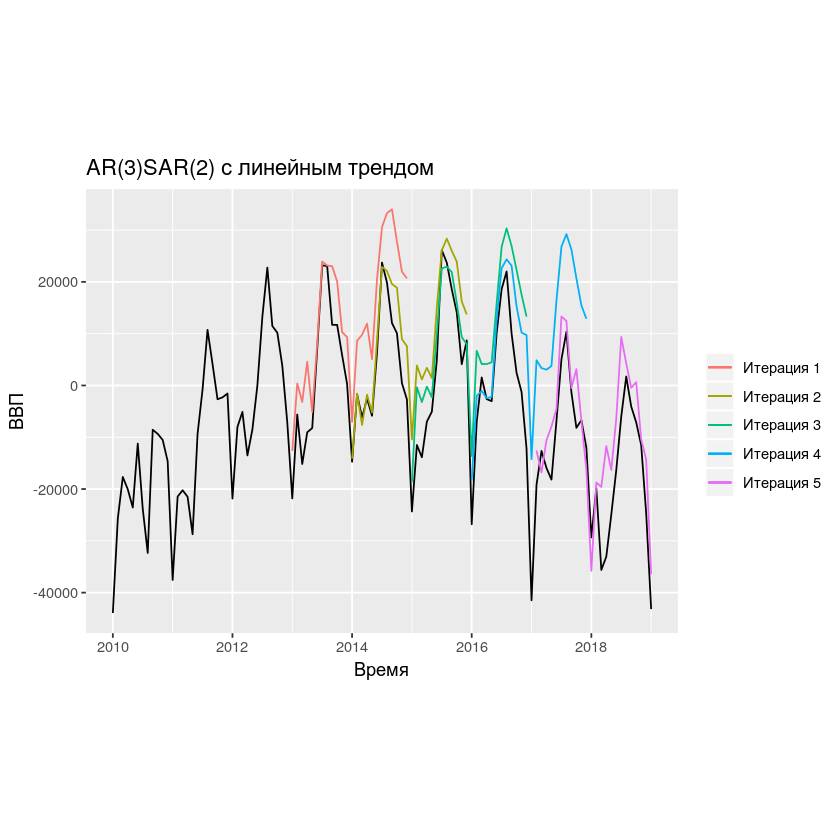

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9121.6994 11548.6450   238.7491    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12873.06
2 level (type),75.78587,352.6453,11896.23
2 level (clusetered),77.77636,271.5424,12057.29


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12873.06
2 level (type),75.78587,352.6453,11548.65
2 level (clusetered),77.77636,271.5424,12057.29


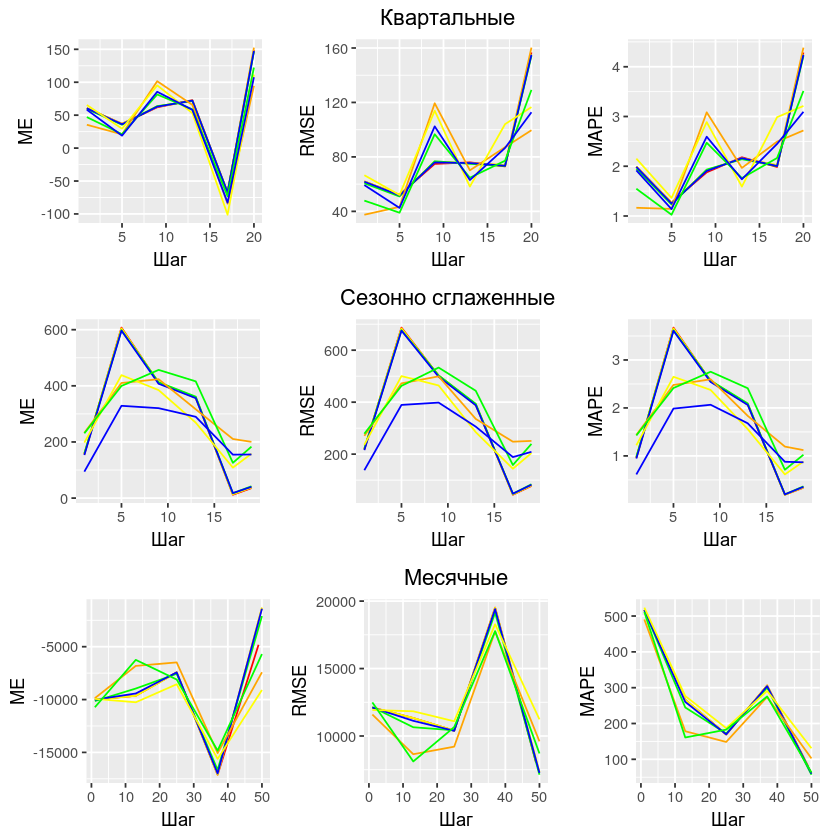

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }


    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[4]]  <-  this_model_list



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-10504.459,12290.610,513.56688,1
-4145.606,6432.627,127.64651,13
-7702.176,10286.237,174.79718,25
-14040.647,16858.065,260.61478,37
-6558.580,9139.998,79.04785,50


In [54]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12249.5863 -16827.8186 -11397.1509  -8146.2564  -3693.1188  13655.0686
 [7]  14211.9041   1402.4987   3355.9756  -5454.9107 -14780.8953 -34771.3765
[13] -17157.4189 -18187.9366 -11772.3105 -15404.3890  -5280.5907  10226.5219
[19]   6146.6711   1105.5970    761.0059  -8878.1572 -13363.7316 -35648.6769

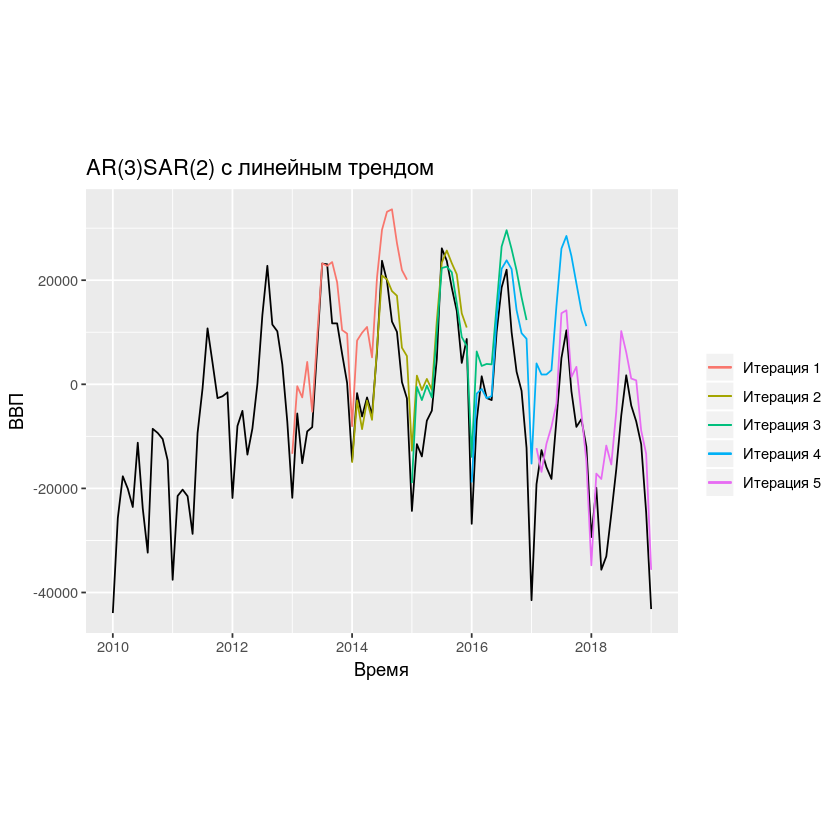

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-8590.2935 11001.5073   231.1346    25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12873.06
2 level (type),75.78587,352.6453,11548.65
2 level (clusetered),77.77636,271.5424,12057.29


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,76.19812,346.0959,11362.29
2 level (state),85.22300,305.4990,12873.06
2 level (type),75.78587,352.6453,11548.65
2 level (clusetered),77.77636,271.5424,11001.51


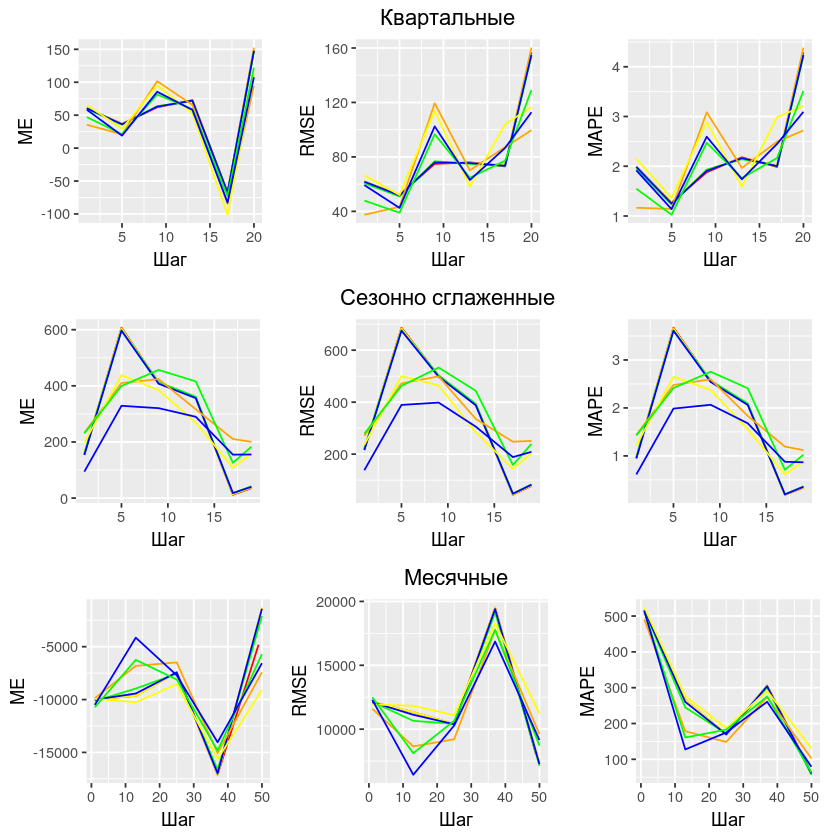

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:

saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")



In [62]:
all_models_list <- readRDS("all_models_list.rds")
all_models_list[[3]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")


